In [1]:
import glob
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import json
import ast
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import datetime
import tsfel
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder 

path = os.getcwd()

all_txt_ls = os.listdir(path + '/data')

len(all_txt_ls)

!du data

all_filename_ls = []

for file in all_txt_ls:
    if file.endswith('txt'):
        file_name = file.split('-')[-1][:-4]
        with open(path + '/data/' + file, 'r') as json_file:
            try:
                data = json.load(json_file)
                print(file, data.keys())
                all_filename_ls.append(file_name)

            except:
                pass

plt.figure(figsize=(20,10))
plt.xticks(fontsize=14, rotation=90)
plt.hist(all_filename_ls)

In [2]:
#file_name = 'April_2021_with audio surveys-WASH - SurveyID mapping including Question UUIDs.xlsx'

#file_name = 'Aug_2021_SurveyID mapping including Question UUIDs  - WASH survey version.xlsx'

file_name = 'Nov_2021_SurveyID mapping including Question UUIDs  - Nov2021.xlsx'

dfs = pd.read_excel(file_name, sheet_name=None, engine='openpyxl')

In [3]:
dfs.keys()

dict_keys(['SIDs by day', 'Baseline', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'End of Study Survey', 'STATIC by day', 'Audio Survey', 'Audio Features', 'Context Survey'])

In [4]:
#dfs['Context Survey']

In [5]:
Question_to_Measure_dict = {
    "Please press start when you are ready for the first step of the activity\nInstructions:\n- Put the phone in your pocket (skip the question if you don't have any)\n- Open bathroom door \n- Go into the bathroom \n- Sit down on the toilet for 10 seconds \n- Get up \n- Flush toilet \n- Wash and dry hands \n- Come out of bathroom \n- Close bathroom door\nThis activity is optional and will not effect your payments": ["Bathroom Usage"],
                            
    "Please press start when you have the items ready the for activity\nInstruction:\n- Put the phone in your pocket (skip the question if you don't have any)\n- Put (pack) any 5 items into a bag. (e.g. water bottle, books, Clothes, packaged food, flashlight, sleeping bag)\nThis activity is optional and will not effect your payments": ["Pack a Bag"],
                            
    "Please press start when you have the items ready for the activity\nInstruction:\n- Put the phone in your pocket (skip the question if you don't have any)\n- Wear a backpack and walk with a constant pace and pronounced arm swing (army march) around the room\nThis activity is optional and will not effect your payments": ["March with a Backpack"], 
                            
    "Please press start when you have the items ready for the activity\nInstruction:\n- Put the phone in your pocket (skip the question if you don't have any)\n- Lift and lower any load (e.g. A collection of books or a box filled with random items) 15 times from the floor-level to above hip-level then back to floor-level.\nThis activity is optional and will not effect your payments": ["Lift and Lower Object"],
                            
    "Please press start when you have the items ready for the activity\nInstruction:\n- Put the phone in your pocket (skip the question if you don't have any)\n- Lift and carry load (e.g. A collection of books or a box filled with random items) and walk for 45 seconds\nThis activity is optional and will not effect your payments": ["Lift and Carry Load"]    
}

In [6]:
all_question_UUID_ls = []
UUID_question_dict = {}


#for sheet in dfs.keys():
for sheet in ['Context Survey']:
    if 'Question UUID for Queries' in dfs[sheet].columns:
        all_question_UUID_ls.extend(dfs[sheet]['Question UUID for Queries'].to_list())
        for UUID in dfs[sheet]['Question UUID for Queries'].to_list():
            if isinstance(UUID, str) and len(UUID) == 36 and len(UUID.split('-')) == 5:
                try:
                    question_str = dfs[sheet].loc[dfs[sheet]['Question UUID for Queries']==UUID]['Questions '].values 
                    if '\n' not in question_str[0]:
                        UUID_question_dict[UUID] = question_str
                    else:
                        UUID_question_dict[UUID] = Question_to_Measure_dict[question_str[0]]
                except KeyError:
                    continue

                
for UUID in UUID_question_dict.keys():
    try:
        UUID_question_dict[UUID] = UUID_question_dict[UUID][0]
    except IndexError:
        #print(UUID_question_dict[UUID])
        continue

UUID_question_dict

all_question_UUID_ls

In [7]:
#data_path = './wash-helpers-0.2/downloads/new_context'
old_data_path = './wash-helpers-0.2/downloads/new_context_QualifiedUsers'

writerIDs_ls = os.listdir(old_data_path)

In [8]:
bad_data_path = './tacc_data/bad_actors_Mar6_2022'

BadActorIDs_ls = os.listdir(bad_data_path)

In [9]:
BadActorIDs_ls

['42dde845-e9b4-4e76-8a33-d632cd8799cd',
 '2f76a31e-1da0-4e38-b23c-cb8dd968d6f7',
 'e6eccdc7-bb9b-4b44-ba7c-f0fb832a02f6',
 '8d93e797-7bf1-44c1-9e8e-c4f464d8ae48']

In [10]:
good_data_path = './tacc_data/good_actors_Mar6_2022'

GoodActorIDs_ls = os.listdir(good_data_path)

In [11]:
GoodActorIDs_ls

['85881003-bfa2-4aad-a144-0f0f7fb3dcfd',
 'c75c240a-788a-4e27-9332-67b88e0132fe',
 '257356ea-fd3d-45a7-abd0-4635d209e502',
 '84fa4d6d-a41f-403b-93a4-498e3bed3eb5',
 '160ec48e-f399-4b72-9790-dbbcc4819ac7',
 '8e03e2fe-ec19-451a-9920-8297e4c4d9f2',
 '3065afb7-8559-414b-abdd-96cdf7a0ac65',
 '5af73f9f-67cb-4420-a398-97d7d85aab95',
 '730c9f85-c9f0-4983-b34f-e35a6f1d8475',
 '69d9bc43-a2d6-465c-a564-21b4db2a6aaa',
 '5576c228-0949-4b58-a933-cc2bf402c729',
 '3bcc1fc0-4333-4309-bba5-3e0763f9262e',
 'f90cfe25-6b5f-4acb-a9c8-5b1e5becc7a1',
 '97520f2b-4bec-4016-bc02-b749fff88aaa',
 'f69f3c3d-a7f0-4006-b4cd-a01999fe4d7a',
 'f47eea72-5d20-4e9e-8a5d-ab90d9e649b0',
 '24653837-9214-4419-8966-a60e221497f1',
 '9cc4a0bf-96b7-44ad-a008-9c3f9f821a57',
 '477e1103-71a4-4050-99eb-388b71f634d6',
 '0078ce68-1692-44fd-9f68-547ed2b1a34c',
 '8c6fc909-da26-4e3d-b443-e41d1a05689f',
 '678c65a3-3b27-4caa-8e07-908f3e086568',
 '63d90887-3f66-46e8-bc9f-2e623532f3ef',
 '3c68c43a-c83c-44b0-92e5-c6801ce17316',
 '820400bb-b9c8-

In [12]:
set(GoodActorIDs_ls).intersection(set(BadActorIDs_ls))

set()

In [13]:
json_data_i_ls = []
json_data_a_ls = []

for writerID in writerIDs_ls:
    deviceIDs_ls = os.listdir(f'{old_data_path}/{writerID}/')
    for deviceID in deviceIDs_ls:
        file_ls = os.listdir(f'{old_data_path}/{writerID}/{deviceID}')
        for file in file_ls:
            if 'i-kry-sensor-survey' in f'{old_data_path}/{writerID}/{deviceID}/{file}':
                with open(f'{old_data_path}/{writerID}/{deviceID}/{file}') as f:
                    try:
                        json_data_i_ls.append(json.load(f))
                    except:
                        continue

            elif 'a-kry-sensor-survey' in f'{old_data_path}/{writerID}/{deviceID}/{file}':
                with open(f'{old_data_path}/{writerID}/{deviceID}/{file}') as f:
                    try:
                        json_data_a_ls.append(json.load(f))
                    except:
                        continue

In [14]:
# build function without device ID

def get_json(data_path):
    json_data_i_ls = []
    json_data_a_ls = []
    writerIDs_ls = os.listdir(f'{data_path}')
    
    for writerID in writerIDs_ls:
        file_ls = os.listdir(f'{data_path}/{writerID}')
        for file in file_ls:
            if 'metadata' not in file:
                with open(f'{data_path}/{writerID}/{file}') as f:
                    file_json = json.load(f)
                    if 'i-kry-sensor' in ' '.join(file_json.keys()):
                        try:
                            json_data_i_ls.append(file_json)
                        except:
                            continue
                    else:
                        try:
                            json_data_a_ls.append(file_json)
                        except:
                            continue
    return json_data_i_ls, json_data_a_ls

In [15]:
json_data_i_ls, json_data_a_ls = get_json(good_data_path)

os.listdir(f'{data_path}/{writerID}/{deviceID}')

In [16]:
len(json_data_i_ls)

1431

In [17]:
for idx in range(len(json_data_i_ls)):
    print(json_data_i_ls[idx])
    if 'i-kry-sensor-survey-daily' in json_data_i_ls[idx].keys():
        print(json_data_i_ls[idx])

In [ ]:
len(json_data_a_ls)

32698

iphone_key = 'i-kry-sensor-survey-daily'
idx = 4

for ans in (json_data_i_ls[idx][iphone_key]):
    if (ans['questionUUID'] in all_question_UUID_ls):
        print(ans)
        print(ans.keys())
        item_ls = ans['answer'].split('\n')
        for item in item_ls:
            if item.startswith('    endTime = '):
                endTime = float(item.split('"')[1])
            if item.startswith('    startTime = '):
                startTime = float(item.split('"')[1])
        print(endTime - startTime)
        activity_str = UUID_question_dict[ans['questionUUID']]
        activity_ls = activity_str.split(' ')
        activity = activity_ls[6] 
        if activity_ls[0] != 'Did' and activity_ls[0] != 'Please':
            for i in activity_ls[activity_ls.index('and'): activity_ls.index('for')]:
                activity += ' ' + i
        else:
            activity = 'skip ' + item_ls[0]
        print(activity)
        print()

# simple activity + plot out histogram for iphone

iphone_key = 'i-kry-sensor-survey-daily'

activity_length = {}
for idx in range(len(json_data_i_ls)):
    for ans in (json_data_i_ls[idx][iphone_key]):
        if (ans['questionUUID'] in all_question_UUID_ls):
            item_ls = ans['answer'].split('\n')
            for item in item_ls:
                if 'stopTime' in item:
                    endTime = float(item.split('"')[2].replace(':','').replace(',',''))
                if 'startTime' in item:
                    startTime = float(item.split('"')[-1].replace(':','').replace('}',''))
            length = endTime - startTime
            activity_str = UUID_question_dict[ans['questionUUID']]
            activity_ls = activity_str.split(' ')
            try:
                activity = activity_ls[6] 
                for i in activity_ls[activity_ls.index('and'): activity_ls.index('for')]:
                    activity += ' ' + i
                if activity not in activity_length:
                    activity_length[activity] = [length]
                else:
                    activity_length[activity].append(length)
            except:
                #print(activity_str)
                pass

for key in activity_length:
    fig = plt.figure()
    plt.hist(activity_length[key])
    plt.title(key)

In [57]:
# complex activity + plot out histogram for iphone

iphone_key = 'i-kry-sensor-survey-daily'

activity_length = {}
for idx in range(len(json_data_i_ls)):
    if iphone_key in json_data_i_ls[idx].keys():
        for ans in (json_data_i_ls[idx][iphone_key]):
            if (ans['questionUUID'] in all_question_UUID_ls):
                item_ls = ans['answer'].split('\n')
                for item in item_ls:
                    if 'stopTime' in item:
                        endTime = float(item.split('"')[2].replace(':','').replace(',',''))
                    if 'startTime' in item:
                        startTime = float(item.split('"')[-1].replace(':','').replace('}',''))
                length = endTime - startTime
                activity_str = UUID_question_dict[ans['questionUUID']]
                
                if 'Did' not in activity_str:
                    if activity_str not in activity_length:
                        activity_length[activity_str]  = [length]
                    else:
                        activity_length[activity_str].append(length)

for key in activity_length:
    fig = plt.figure()
    plt.hist(activity_length[key])
    plt.title(key)

KeyError: 'i-kry-sensor-survey-daily'

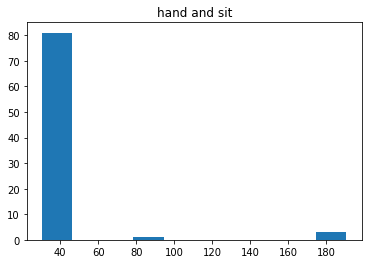

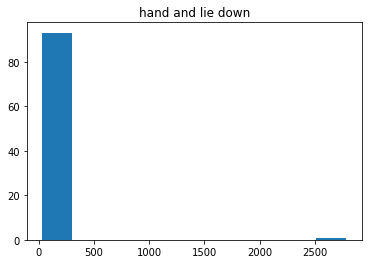

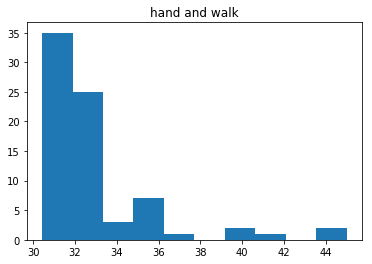

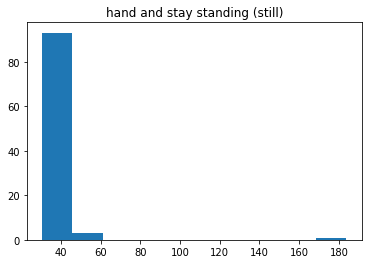

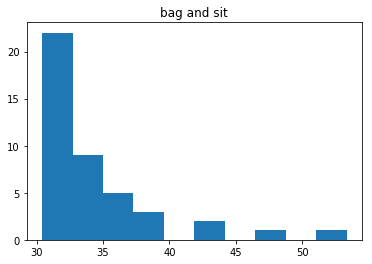

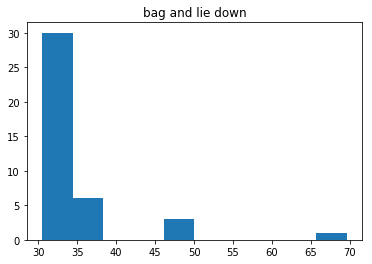

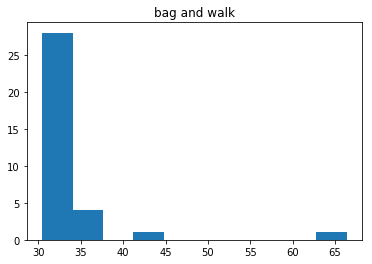

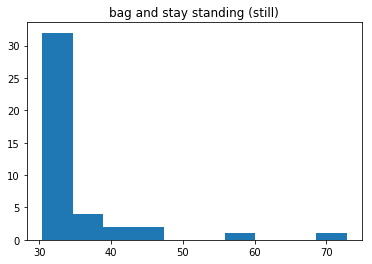

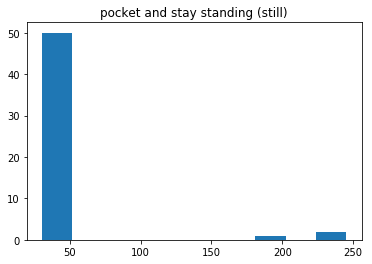

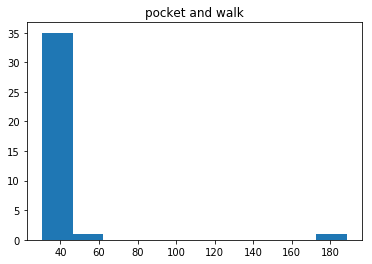

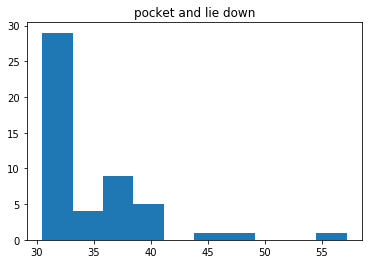

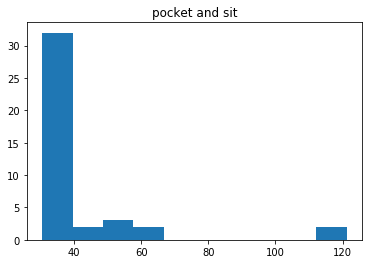

In [90]:
android_key = 'records'

# plot out histogram for android

activity_length = {}
for idx in range(len(json_data_a_ls)):
    for ans in (json_data_a_ls[idx][android_key]):
        if (ans['questionUUID'] in all_question_UUID_ls):
            if ans['answer'].startswith('{"startTime'):
                answer_time_dict = json.loads(ans['answer'])
                startTime = answer_time_dict['startTime'] / 1000
                endTime = answer_time_dict['stopTime'] / 1000
                length = endTime - startTime
                activity_str = UUID_question_dict[ans['questionUUID']]
                activity_ls = activity_str.split(' ')
                try:
                    activity = activity_ls[6] 
                    for i in activity_ls[activity_ls.index('and'): activity_ls.index('for')]:
                        activity += ' ' + i
                    if activity not in activity_length:
                        activity_length[activity] = [length]
                    else:
                        activity_length[activity].append(length)
                except:
                    #print(activity_str)
                    pass

for key in activity_length:
    fig = plt.figure()
    plt.hist(activity_length[key])
    plt.title(key)

#### UUID in xlsx

for json_data in json_data_a_ls:
    for record in json_data['records']:
        if record['questionUUID'] not in UUID_question_dict:
            print(record['questionUUID'])

for json_data in json_data_i_ls:
    for record in json_data['i-kry-sensor-survey-daily']:
        if 'questionUUID' in record:
            if record['questionUUID'] in UUID_question_dict:
                print('questionUUID', record['questionUUID'])
        elif 'uuid' in record:
            if record['uuid'] in UUID_question_dict:
                if record['uuid']+'\n' not in UUID_question_dict:
                    print('uuid', record['uuid'], record)
                    print()
        else:
            print(record)

### get writerID with 30s acitivity
#### each file has time-stamp for 30s acitivity

In [13]:
writerIDs_ls = os.listdir(data_path)

In [14]:
with open('writerID_ls.npy', 'wb') as f:
    np.save(f, writerIDs_ls)

In [15]:
json_data_i_dict = {}
json_data_a_dict = {}

for writerID in writerIDs_ls:
    deviceIDs_ls = os.listdir(f'{data_path}/{writerID}/')
    for deviceID in deviceIDs_ls:
        file_ls = os.listdir(f'{data_path}/{writerID}/{deviceID}')
        for file in file_ls:
            if 'i-kry-sensor-survey' in f'{data_path}/{writerID}/{deviceID}/{file}':
                with open(f'{data_path}/{writerID}/{deviceID}/{file}') as f:
                    try:
                        if writerID in json_data_i_dict:
                            json_data_i_dict[writerID].append(json.load(f))
                        else:
                            json_data_i_dict[writerID] = [json.load(f)]
                    except:
                        continue

            elif 'a-kry-sensor-survey' in f'{data_path}/{writerID}/{deviceID}/{file}':
                with open(f'{data_path}/{writerID}/{deviceID}/{file}') as f:
                    try:
                        if writerID in json_data_a_dict:
                            json_data_a_dict[writerID].append(json.load(f))
                        else:
                            json_data_a_dict[writerID] = [json.load(f)]
                    except:
                        continue

In [16]:
iphone_key = 'i-kry-sensor-survey-daily'

# filter out too long or too short acitivity for iphone
json_data_i_dict_filtered = {}

for writerID in json_data_i_dict:
    for ans_ls in (json_data_i_dict[writerID]):
        for ans in ans_ls[iphone_key]:
            if (ans['questionUUID'] in all_question_UUID_ls):
                item_ls = ans['answer'].split('\n')
                for item in item_ls:
                    if item.startswith('    endTime = '):
                        endTime = float(item.split('"')[1])
                    if item.startswith('    startTime = '):
                        startTime = float(item.split('"')[1])
                length = endTime - startTime
                if length > 5 and length < 60:
                    if writerID not in json_data_i_dict_filtered:
                        json_data_i_dict_filtered[writerID]={iphone_key :[ans]}
                    else:
                        json_data_i_dict_filtered[writerID][iphone_key].append(ans)

In [17]:
android_key = 'records'

# filter out too long or too short acitivity for android
json_data_a_dict_filtered = {}

for writerID in json_data_a_dict:
    for ans_ls in (json_data_a_dict[writerID]):
        for ans in ans_ls[android_key]:
            if (ans['questionUUID'] in all_question_UUID_ls):
                if ans['answer'].startswith('{"startTime'):
                    answer_time_dict = json.loads(ans['answer'])
                    startTime = answer_time_dict['startTime'] / 1000
                    endTime = answer_time_dict['stopTime'] / 1000
                    length = endTime - startTime
                    if length > 5 and length < 60:
                        if writerID not in json_data_a_dict_filtered:
                            json_data_a_dict_filtered[writerID]={android_key :[ans]}
                        else:
                            json_data_a_dict_filtered[writerID][android_key].append(ans)

In [18]:
iphone_key = 'i-kry-sensor-survey-daily'

# get formatted dictionary {writerID: {activity: [startTime, endTime]}} for iphone
json_data_i_dict_formatted = {}

for writerID in json_data_i_dict:
    for ans_ls in (json_data_i_dict[writerID]):
        for ans in ans_ls[iphone_key]:
            if (ans['questionUUID'] in all_question_UUID_ls):
                item_ls = ans['answer'].split('\n')
                for item in item_ls:
                    if item.startswith('    endTime = '):
                        endTime = float(item.split('"')[1])
                    if item.startswith('    startTime = '):
                        startTime = float(item.split('"')[1])
                length = endTime - startTime
                activity_str = UUID_question_dict[ans['questionUUID']]
                activity_ls = activity_str.split(' ')
                try:
                    activity = activity_ls[6] 
                    for i in activity_ls[activity_ls.index('and'): activity_ls.index('for')]:
                        activity += ' ' + i
                    
                    if writerID not in json_data_i_dict_formatted:
                        json_data_i_dict_formatted[writerID] = {}
                    #print(json_data_i_dict_formatted)    
                    if activity not in json_data_i_dict_formatted[writerID]:
                        json_data_i_dict_formatted[writerID].update({activity: [[startTime, endTime]]})
                    else:
                        json_data_i_dict_formatted[writerID][activity].append([startTime, endTime])
                except:
                    #print(activity_str)
                    pass

In [19]:
android_key = 'records'

# get formatted dictionary {writerID: {activity: [startTime, endTime]}} for android
json_data_a_dict_formatted = {}

for writerID in json_data_a_dict:
    for ans_ls in (json_data_a_dict[writerID]):
        for ans in ans_ls[android_key]:
            if (ans['questionUUID'] in all_question_UUID_ls):
                if ans['answer'].startswith('{"startTime'):
                    answer_time_dict = json.loads(ans['answer'])
                    startTime = answer_time_dict['startTime'] / 1000
                    endTime = answer_time_dict['stopTime'] / 1000
                    length = endTime - startTime
                    activity_str = UUID_question_dict[ans['questionUUID']]
                    activity_ls = activity_str.split(' ')
                    try:
                        activity = activity_ls[6] 
                        for i in activity_ls[activity_ls.index('and'): activity_ls.index('for')]:
                            activity += ' ' + i

                        if writerID not in json_data_a_dict_formatted:
                            json_data_a_dict_formatted[writerID] = {}    
                        if activity not in json_data_a_dict_formatted[writerID]:
                            json_data_a_dict_formatted[writerID].update({activity: [[startTime, endTime]]})
                        else:
                            json_data_a_dict_formatted[writerID][activity].append([startTime, endTime])
                    except:
                        #print(activity_str)
                        pass

In [20]:
with open('json_data_i_dict_formatted.p', 'wb') as f:
    pickle.dump(json_data_i_dict_formatted, f)

In [21]:
with open('json_data_a_dict_formatted.p', 'wb') as f:
    pickle.dump(json_data_a_dict_formatted, f)

In [22]:
activity_count_dict = {}

for writerID in json_data_i_dict_formatted:
    activity_ls = json_data_i_dict_formatted[writerID].keys()
    for activity in activity_ls:
        if activity not in activity_count_dict:
            activity_count_dict[activity] = 1
        else:
            activity_count_dict[activity] += 1
            
activity_count_dict

{}

In [23]:
activity_count_dict = {}

for writerID in json_data_a_dict_formatted:
    activity_ls = json_data_a_dict_formatted[writerID].keys()
    for activity in activity_ls:
        if activity not in activity_count_dict:
            activity_count_dict[activity] = len(json_data_a_dict_formatted[writerID][activity])
        else:
            activity_count_dict[activity] += len(json_data_a_dict_formatted[writerID][activity])
            
activity_count_dict

{'hand and sit': 85,
 'hand and lie down': 94,
 'hand and walk': 76,
 'hand and stay standing (still)': 97,
 'bag and sit': 43,
 'bag and lie down': 40,
 'bag and walk': 34,
 'bag and stay standing (still)': 42,
 'pocket and stay standing (still)': 53,
 'pocket and walk': 37,
 'pocket and lie down': 50,
 'pocket and sit': 41}

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

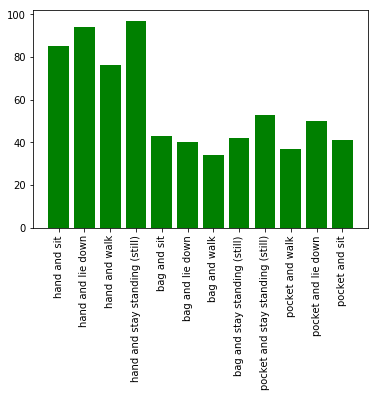

In [24]:
plt.bar(activity_count_dict.keys(), activity_count_dict.values(), color='g')
plt.xticks(rotation = 90)

### create feature + label dataframe

In [25]:
data_path = data_path = './downloads/trial'
writerID_SensorDir = os.listdir(data_path)

writerID_label30s = []
for writerID in json_data_i_dict_formatted:
    writerID_label30s.append(writerID)

In [26]:
len(writerID_label30s)

0

In [27]:
len(writerID_SensorDir)

48

with open('writerID_label30s.npy', 'wb') as f:
    np.save(f, writerID_label30s)

In [28]:
writerIDs_candidate = list(set(writerID_SensorDir) & set(writerID_label30s))

In [29]:
len(writerIDs_candidate)

0

writer_label_sensor_dict = {}

# each writer
for writerID in writerIDs_candidate:
    activity_ls = json_data_i_dict_formatted[writerID].keys()
    
    if writerID not in writer_label_sensor_dict:
        writer_label_sensor_dict[writerID] = {}
    
    # each writer's each activity (now seeing one user has one activity)
    for activity in activity_ls:
        for trial in json_data_i_dict_formatted[writerID][activity]:
            startTime= int(trial[0])
            endTime= int(trial[1])

            if activity not in writer_label_sensor_dict[writerID]:
                writer_label_sensor_dict[writerID][activity] = {}

            for file in os.listdir(f'{data_path}/{writerID}/'):
                if file.startswith('i') and file.split('-')[3] != 'survey':
                    sensor_type = file.split('-')[3]
                    sensor_key = file.split('_')[0]
                    
                    with open(f'{data_path}/{writerID}/{file}') as f:    
                        try:
                            js = json.load(f)
                        except:
                            print(file)
                            continue
                        timeseries_ls = js[sensor_key]
                        feature_ls = []
                        
                        first_timestamp = int(float(timeseries_ls[0]['timestamp']))
                        last_timestamp = int(float(timeseries_ls[-1]['timestamp']))
                    
                        if first_timestamp < startTime and endTime < last_timestamp:
                            #print(file)
                            pass

                        for timestamp in timeseries_ls:

                            if int(startTime) < int(float(timestamp['timestamp'])) < int(endTime):
                                feature_ls = list(timestamp.keys())
                                feature_ls.remove('timestamp')
                                
                                for feature in feature_ls:
                                    feature_full = sensor_type + '_' + feature
                                    if feature_full not in writer_label_sensor_dict[writerID][activity]:
                                        writer_label_sensor_dict[writerID][activity][feature_full] = [timestamp[feature]]
                                    else:
                                        writer_label_sensor_dict[writerID][activity][feature_full].append(timestamp[feature])
                                        
                        if feature_ls:
                            #print(feature_ls)
                            pass

with open('writer_label_sensor_dict.p', 'wb') as f:
    pickle.dump(writer_label_sensor_dict, f)

In [30]:
with open('writer_label_sensor_dict.p', 'rb') as f:
    writer_label_sensor_dict = pickle.load(f)

In [31]:
writer_label_sensor_dict_filtered = {}

# filter to only have 3 main features

for writerID in writer_label_sensor_dict.keys():
    for activity in writer_label_sensor_dict[writerID].keys():
        featureName_ls = []
        for feature_full in writer_label_sensor_dict[writerID][activity].keys():
            featureName_ls.append(feature_full.split('_')[0])
        featureName_ls = list(set(featureName_ls))
        
        featureCandidates = ['accelerometer', 'magnetometer', 'gyroscope']
        
        # write to new dict if 3 main features exist
        if all(featureCan in featureName_ls for featureCan in featureCandidates):
            
            # check if writerID in
            if writerID not in writer_label_sensor_dict_filtered:
                writer_label_sensor_dict_filtered[writerID] = {}
                
            # check if activity in
            if activity not in writer_label_sensor_dict_filtered[writerID]:
                writer_label_sensor_dict_filtered[writerID].update({activity: {}})
                
                # only write those 3 features to new dict  
                for feature_fullname in writer_label_sensor_dict[writerID][activity].keys():
                    if feature_fullname.split('_')[0] in featureCandidates:
                        feature_name = feature_fullname.split('_')[0] + '_' + feature_fullname.split('_')[-1]
                        writer_label_sensor_dict_filtered[writerID][activity].update({feature_name: 
                                                                                      writer_label_sensor_dict[writerID][activity][feature_fullname]})
            else:
                # only write those 3 features to new dict    
                for feature_fullname in writer_label_sensor_dict[writerID][activity].keys():
                    if feature_fullname.split('_')[0] in featureCandidates:
                        feature_name = feature_fullname.split('_')[0] + '_' + feature_fullname.split('_')[-1]
                        writer_label_sensor_dict_filtered[writerID][activity].update({feature_name: 
                                                                                      writer_label_sensor_dict[writerID][activity][feature_fullname]})

i = 0
for writerID in writer_label_feature_dict.keys():
    for activity in writer_label_feature_dict[writerID].keys():
        i = i + 1
        for feature_fullname in writer_label_feature_dict[writerID][activity].keys():
            
            print(feature_fullname, len(writer_label_feature_dict[writerID][activity][feature_fullname]))
print(i)

In [32]:
cfg = tsfel.get_features_by_domain("statistical")

writer_label_feature_dict = {}

for writerID in writer_label_sensor_dict_filtered.keys():
    print(writerID)
    if writerID not in writer_label_feature_dict:
        writer_label_feature_dict[writerID] = {}
    
    for activity in writer_label_sensor_dict_filtered[writerID].keys():
        if activity not in writer_label_feature_dict[writerID]:
            writer_label_feature_dict[writerID].update({activity: {}})
        
        for feature_fullname in writer_label_sensor_dict_filtered[writerID][activity].keys():
            try:
                extracted_feature = \
                tsfel.time_series_features_extractor(cfg, 
                                                     writer_label_sensor_dict_filtered[writerID][activity][feature_fullname], 
                                                     verbose =0)
                
                # normalize
                extracted_feature_v = extracted_feature.values.reshape(-1,)
                extracted_feature_n = extracted_feature_v / np.sqrt(np.sum(extracted_feature_v**2))
                
                if feature_fullname not in writer_label_feature_dict[writerID][activity]:
                    writer_label_feature_dict[writerID][activity][feature_fullname] = extracted_feature_n
                    
                    if len(extracted_feature_n) != 36:
                        print([writerID,activity,feature_fullname], end=' ')
                
            except:
                print(writerID, activity, feature_fullname, 
                      len(writer_label_sensor_dict_filtered[writerID][activity][feature_fullname]))
                del writer_label_sensor_dict_filtered[writerID][activity]
                break

a2fffd3e-54fa-42bc-91b4-be76794120e4


/home/grads/g/guangzhou92/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Using default sampling frequency set in configuration file.


b76c29ad-8f0b-4c9a-8439-cc1e2a757b46
e1da6990-90bd-4234-90b0-a386d8f23a63
1cabfadf-8cc2-4f1f-8340-742ab22b82cc
4e720d5b-3b76-4d54-8dbf-196f0dae81ea
4e720d5b-3b76-4d54-8dbf-196f0dae81ea hand and stay standing (still) magnetometer_y 3


RuntimeError: dictionary changed size during iteration

In [ ]:
featureCandidates = ['accelerometer', 'magnetometer', 'gyroscope']
axes = ['x', 'y', 'z']

sensor_features = []

for feature in featureCandidates:
    for axis in axes:
        sensor_features.append(feature + '_' + axis)

In [ ]:
sensor_features

['accelerometer_x',
 'accelerometer_y',
 'accelerometer_z',
 'magnetometer_x',
 'magnetometer_y',
 'magnetometer_z',
 'gyroscope_x',
 'gyroscope_y',
 'gyroscope_z']

In [ ]:
writer_label_feature_dict[writerID][activity].update({'features': extracted_feature.columns})

df =  pd.DataFrame.from_dict(writer_label_feature_dict[writerID][activity])

df = df.set_index('features')
columns = df.columns
indexes = df.index

featurename_ls = []
values = []
for column in sensor_features:
    for index in indexes:
        featurename_ls.append(column+index[1:])
        values.append(df[column][index])

In [ ]:
df_all  = pd.DataFrame(columns=featurename_ls)
label_ls = []
activity_ls = []
phone_ls = []

for writerID in writer_label_feature_dict.keys():
    for activity in writer_label_feature_dict[writerID].keys():

        # each activity dict to df
        writer_label_feature_dict[writerID][activity].update({'features': extracted_feature.columns})
        try:
            df =  pd.DataFrame.from_dict(writer_label_feature_dict[writerID][activity])
            label_ls.append(activity)
            activity_ls.append(activity.split(' and ')[1])
            phone_ls.append(activity.split(' and ')[0])
        except:
            for feature in writer_label_feature_dict[writerID][activity]:
                print(writerID,activity,feature_fullname, end=' ') 
                print(len(writer_label_feature_dict[writerID][activity][feature]))
            continue
            
        df = df.set_index('features')
        
        columns = df.columns
        indexes = df.index

        featurename_ls = []
        values = []
        for column in sensor_features:
            for index in indexes:
                featurename_ls.append(column+index[1:])
                values.append(df[column][index])
        
        if (list(featurename_ls) == list(df_all.columns)):
            df_new = pd.DataFrame(np.array(values).reshape(1,-1), columns=featurename_ls)
            df_all = df_all.append(df_new)

df_all['label'] = label_ls
df_all['activity'] = activity_ls
df_all['phone'] = phone_ls

f0472b67-ae6a-499c-8e10-44f765a329e2 pocket and walk gyroscope_x 36
f0472b67-ae6a-499c-8e10-44f765a329e2 pocket and walk gyroscope_x 36
f0472b67-ae6a-499c-8e10-44f765a329e2 pocket and walk gyroscope_x 36
f0472b67-ae6a-499c-8e10-44f765a329e2 pocket and walk gyroscope_x 36
f0472b67-ae6a-499c-8e10-44f765a329e2 pocket and walk gyroscope_x 36
f0472b67-ae6a-499c-8e10-44f765a329e2 pocket and walk gyroscope_x 36
f0472b67-ae6a-499c-8e10-44f765a329e2 pocket and walk gyroscope_x 35
f0472b67-ae6a-499c-8e10-44f765a329e2 pocket and walk gyroscope_x 35
f0472b67-ae6a-499c-8e10-44f765a329e2 pocket and walk gyroscope_x 35
f0472b67-ae6a-499c-8e10-44f765a329e2 pocket and walk gyroscope_x 36


In [ ]:
np.unique(df_all['label'],return_counts=True)

(array(['bag and lie down', 'bag and sit', 'bag and stay standing (still)',
        'bag and walk', 'hand and lie down', 'hand and sit',
        'hand and stay standing (still)', 'hand and walk',
        'pocket and lie down', 'pocket and sit',
        'pocket and stay standing (still)', 'pocket and walk'],
       dtype=object), array([ 4,  4,  3,  3, 17, 15, 15, 16, 10, 10, 14, 13]))

In [ ]:
df_all.to_csv('df_all.csv', index=False)

### basic ML to train/test

In [ ]:
df = pd.read_csv('df_all.csv')

outcome = ['label', 'phone', 'activity']
add_phone_context = True

if add_phone_context:
    df = pd.concat([df, pd.get_dummies(df['phone'])], axis=1)

skf = StratifiedKFold(n_splits=5, shuffle=True)

labels = df['activity'].copy()
df.drop(columns=outcome, inplace=True)

#labels = pd.get_dummies(labels.to_frame())

In [ ]:
lc = LabelEncoder() 
lc.fit(labels) 

for i, (train, test) in enumerate(skf.split(df, labels)):
    print(f'Fold {i}: ', end='')
    train_data = df.iloc[train].copy()
    test_data = df.iloc[test].copy()
    
    
    labels_encoded = lc.transform(labels)
    train_labels=labels_encoded[train]
    test_labels=labels_encoded[test]
    #print(labels)
    #print(labels_encoded)
    
    model = XGBClassifier(objective= 'multi:softprob') 

    model.fit(train_data, train_labels)
    
    y_pred = model.predict(test_data) 
    predictions = [round(value) for value in y_pred]
    
    accuracy = accuracy_score(test_labels, predictions) 
    #accuracy = precision_score(test_labels, best_preds, average='macro')

    print("Accuracy: %.2f%%" % (accuracy * 100.0))

Fold 0: Accuracy: 48.00%
Fold 1: Accuracy: 44.00%
Fold 2: Accuracy: 48.00%
Fold 3: Accuracy: 36.00%
Fold 4: Accuracy: 50.00%


In [ ]:
list(test_labels)

[2, 3, 0, 0, 1, 2, 2, 3, 1, 3, 3, 3, 1, 0, 0, 0, 0, 1, 2, 1, 0, 3, 2, 2]

In [ ]:
predictions

[2, 3, 0, 3, 2, 0, 1, 3, 0, 0, 2, 3, 2, 0, 2, 2, 0, 0, 3, 1, 0, 3, 2, 2]

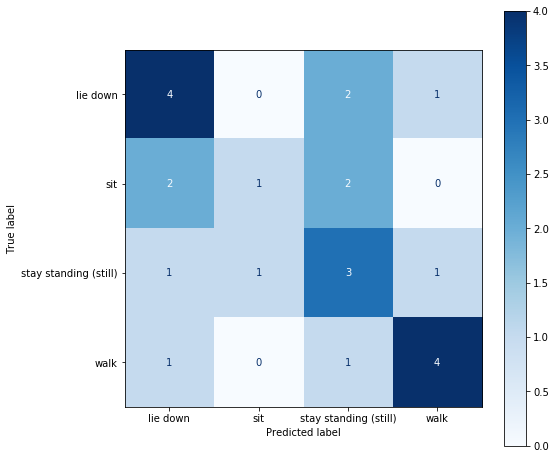

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
disp = plot_confusion_matrix(model, test_data, test_labels,
                                 display_labels=np.unique(labels),
                                 cmap=plt.cm.Blues,
                                 ax=ax)

In [ ]:
for i, (train, test) in enumerate(skf.split(df, labels)):
    print(f'Fold {i}: ', end='')
    train_data = df.iloc[train].copy()
    test_data = df.iloc[test].copy()

    labels = pd.get_dummies(labels.to_frame())
    train_labels=labels.iloc[train].copy()
    test_labels=labels.iloc[test].copy()
    
    
    #train_labels = pd.get_dummies(train_labels).values
    #test_labels = pd.get_dummies(test_labels).values
    
    dtrain = xgb.DMatrix(train_data, label=train_labels.values)
    dtest = xgb.DMatrix(test_data, label=test_labels.values)
    
    param = {
    'max_depth': 30,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 4}  # the number of classes that exist in this datset
    num_round = 20  # the number of training iterations

    bst = xgb.train(param, dtrain, num_round)
    
    preds = bst.predict(dtest)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    
    print(precision_score(test_labels, best_preds, average='macro'))

Fold 0: 

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [ ]:
preds

array([[0.8456546 , 0.07578368, 0.00982021, 0.00982021, 0.00982021,
        0.00982021, 0.00982021, 0.00982021, 0.00982021, 0.00982021],
       [0.9632511 , 0.02721155, 0.00119217, 0.00119217, 0.00119217,
        0.00119217, 0.00119217, 0.00119217, 0.00119217, 0.00119217],
       [0.836715  , 0.05655998, 0.01334063, 0.01334063, 0.01334063,
        0.01334063, 0.01334063, 0.01334063, 0.01334063, 0.01334063],
       [0.86214066, 0.07769257, 0.00752085, 0.00752085, 0.00752085,
        0.00752085, 0.00752085, 0.00752085, 0.00752085, 0.00752085],
       [0.91074526, 0.02748568, 0.00772113, 0.00772113, 0.00772113,
        0.00772113, 0.00772113, 0.00772113, 0.00772113, 0.00772113],
       [0.9466725 , 0.02082576, 0.00406272, 0.00406272, 0.00406272,
        0.00406272, 0.00406272, 0.00406272, 0.00406272, 0.00406272],
       [0.5961928 , 0.21265203, 0.0238944 , 0.0238944 , 0.0238944 ,
        0.0238944 , 0.0238944 , 0.0238944 , 0.0238944 , 0.0238944 ],
       [0.79330134, 0.16853033, 0.0047710

In [ ]:
test_labels

### check health survey trend

In [ ]:
writerIDs_ls = os.listdir(data_path)
#writerID = '5e0bd824-8960-4bc8-9983-90d91b9c4719'

for writerID in writerIDs_ls:
    deviceID_ls = os.listdir(f'{data_path}/{writerID}')
    for deviceID in deviceID_ls:
        file_ls = os.listdir(f'{data_path}/{writerID}/{deviceID}')
        print(len(file_ls), end=' ')
    print(' | ', end=' ')
    '''for file in file_ls:
        with open(f'{data_path}/{writerID}/{deviceID}/{file}') as f:
            js = json.load(f)
        # print all files for one user
        print(js)'''

In [ ]:
file_ls = os.listdir(f'{data_path}/{writerID}/{deviceID}')

In [ ]:
file_ls